In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn import metrics               # AUC for Testing data 
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [28]:
titanic_df = pd.read_csv('C:/Datasets/titanicnew/train.csv')
titanic_df_test = pd.read_csv('C:/Datasets/titanicnew/test.csv')

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


For our problem the target variable is Survived. 0 represents not survived and 1 represents survived. 

**Exploratory Data Analysis and Data cleaning**

In [35]:
len(titanic_df)

891

Let check if the data contains any null values and then remove them subsequently.

In [4]:
print(titanic_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Most of the null values are present in column Cabin. We thus drop the column Cabin, Embarked and PassangerId since they are not important to our analysis. 

In [29]:
titanic_df = titanic_df.drop(['Cabin', 'Embarked', 'PassengerId'], axis=1)

In [7]:
len(titanic_df)

891

In [298]:
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Data Vizualization**

Gender feature

Percentage of females who survived: 74.20382165605095
Percentage of males who survived: 18.890814558058924


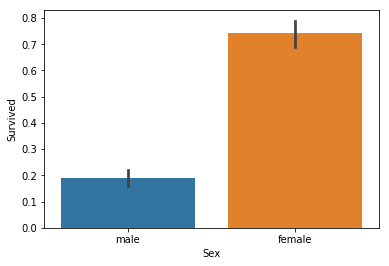

In [31]:
sns.barplot(x="Sex", y="Survived", data=titanic_df)

#print percentages of females vs. males that survive
print("Percentage of females who survived:", titanic_df["Survived"][titanic_df["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("Percentage of males who survived:", titanic_df["Survived"][titanic_df["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

Pclass feature 

Percentage of Pclass = 1 who survived: 62.96296296296296
Percentage of Pclass = 2 who survived: 47.28260869565217
Percentage of Pclass = 3 who survived: 24.236252545824847


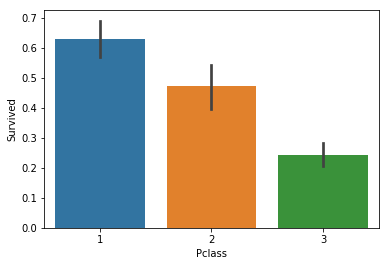

In [33]:
#draw a bar plot of survival by Pclass
sns.barplot(x="Pclass", y="Survived", data=titanic_df)

#print percentage of people by Pclass that survived
print("Percentage of Pclass = 1 who survived:", titanic_df["Survived"][titanic_df["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 2 who survived:", titanic_df["Survived"][titanic_df["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 3 who survived:", titanic_df["Survived"][titanic_df["Pclass"] == 3].value_counts(normalize = True)[1]*100)

Age Feature 

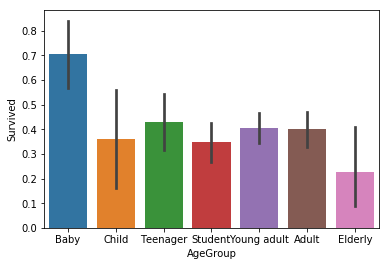

In [8]:
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young adult', 'Adult', 'Elderly']
titanic_df['AgeGroup'] = pd.cut(titanic_df["Age"], bins, labels = labels)
titanic_df['AgeGroup'] = pd.cut(titanic_df["Age"], bins, labels = labels)

# Draw a bar plot for age vs. survival
sns.barplot(x='AgeGroup',y='Survived',data=titanic_df)

We can see now that passengers from first class, women and babies had survived according to our EDA.<br>Lets see if number of siblings and parents/spouses have an affect on survival

sibSp feature

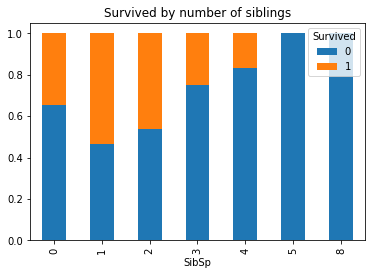

In [303]:
pd.crosstab(titanic_df['SibSp'], titanic_df['Survived'],normalize='index').plot(kind='bar', stacked=True, title="Survived by number of siblings")


Parch Feature 

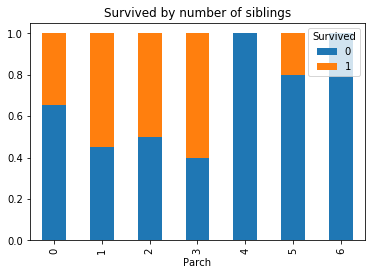

In [7]:
pd.crosstab(titanic_df['Parch'], titanic_df['Survived'],normalize='index').plot(kind='bar', stacked=True, title="Survived by number of siblings")


So from our plots we can see that people who have around 3 siblings or parents & spouse have around 40% chance of survival.

Now lets add the family column using the SibSp and Parch column to see what role the size of the family plays.

In [5]:
titanic_df['Family'] = titanic_df['SibSp'] + titanic_df['Parch'] +1 

In [306]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,AgeGroup,Family
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Student,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Adult,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Young adult,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Young adult,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Young adult,1


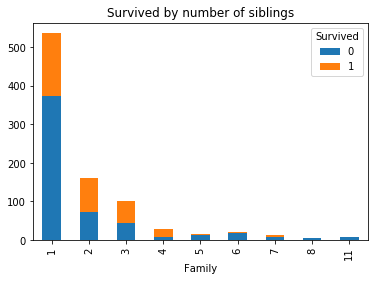

In [9]:
pd.crosstab(titanic_df['Family'], titanic_df['Survived']).plot(kind='bar', stacked=True, title="Survived by number of siblings")


With family size 5 or greater the chances of survival reduces.

We'll fill in the missing values in the Age feature. Since a higher percentage of values are missing, it would be illogical to fill all of them with the same value (as we did with Embarked). Instead, let's try to find a way to predict the missing ages

In [4]:
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(titanic_df['Title'], titanic_df['Sex'])



Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Replacing the titles with more common names.

In [5]:
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
titanic_df['Title'] = titanic_df['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')

titanic_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [310]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,AgeGroup,Family,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Student,2,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Adult,2,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Young adult,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Young adult,2,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Young adult,1,Mr


In [6]:
#map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}


titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,1


Predict the missing age values using the most common age for that particular age title

In [9]:
mr_age = titanic_df[titanic_df["Title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = titanic_df[titanic_df["Title"] == 2]["AgeGroup"].mode() #Student
mrs_age = titanic_df[titanic_df["Title"] == 3]["AgeGroup"].mode() #Adult
master_age = titanic_df[titanic_df["Title"] == 4]["AgeGroup"].mode() #Baby
royal_age = titanic_df[titanic_df["Title"] == 5]["AgeGroup"].mode() #Adult
rare_age = titanic_df[titanic_df["Title"] == 6]["AgeGroup"].mode() #Adult

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

titanic_df = titanic_df.fillna({"Age": titanic_df["Title"].map(age_title_mapping)})


In [143]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,AgeGroup,Family,Title
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,Student,2,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,Adult,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,Young adult,1,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,Young adult,2,3
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,Young adult,1,1


We have now successfuly filled all the missing values for the Age column. Lets check the nan's in our dataframe again.

In [14]:
print(titanic_df.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
AgeGroup    177
Family        0
Title         0
dtype: int64


Now that we have filled the missing values for age. We can proceed further but first lets drop columns Name, AgeGroup and Title as they will not be much useful. 

In [10]:
titanic_df = titanic_df.drop(['Name', 'Title', 'AgeGroup','Ticket'], axis=1)

Lets go ahead and one-hot encode our catagorical variable Sex.

In [11]:
one_hot = pd.get_dummies(titanic_df['Sex'])

In [12]:
titanic_df = titanic_df.drop('Sex',axis = 1)
# Join the encoded df
titanic_df = titanic_df.join(one_hot)

Refer and do feature selection 

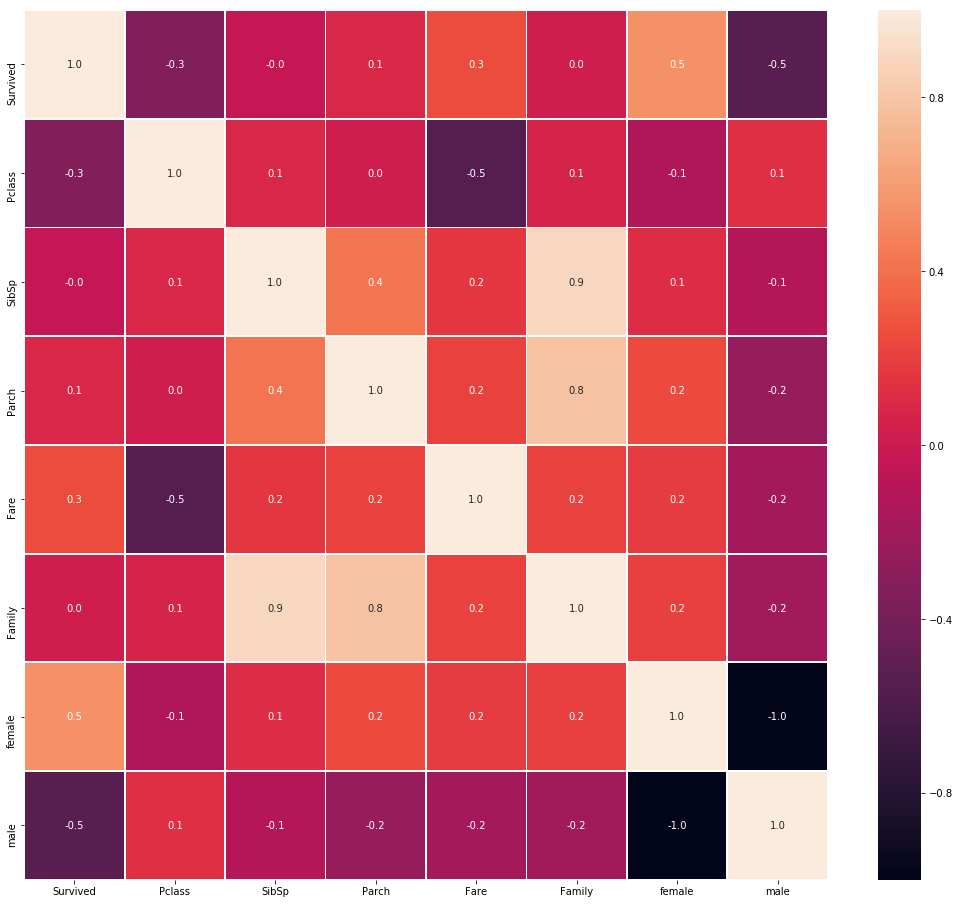

In [18]:
f,ax = plt.subplots(figsize=(18, 16))
sns.heatmap(titanic_df.corr(), annot=True, linewidths=.8, fmt= '.1f',ax=ax)

From the coorelation matrix we can see that the columns SibSp and Parch are higly coorealted with Family. This is called as multicollinearity and it will cause a problem as the independent variables should be independent from each other. Thus we'll go on and drop SibSp and Parch.

There were some strings in our Age table. Lets find and replace them.

In [19]:
titanic_df.Age.unique()

array([22.0, 38.0, 26.0, 35.0, 'Young Adult', 54.0, 2.0, 27.0, 14.0, 4.0,
       58.0, 20.0, 39.0, 55.0, 31.0, 'Adult', 34.0, 15.0, 28.0, 8.0, 19.0,
       'Student', 40.0, 66.0, 42.0, 21.0, 18.0, 3.0, 7.0, 49.0, 29.0,
       65.0, 28.5, 5.0, 11.0, 45.0, 'Baby', 17.0, 32.0, 16.0, 25.0, 0.83,
       30.0, 33.0, 23.0, 24.0, 46.0, 59.0, 71.0, 37.0, 47.0, 14.5, 70.5,
       32.5, 12.0, 9.0, 36.5, 51.0, 55.5, 40.5, 44.0, 1.0, 61.0, 56.0,
       50.0, 36.0, 45.5, 20.5, 62.0, 41.0, 52.0, 63.0, 23.5, 0.92, 43.0,
       60.0, 10.0, 64.0, 13.0, 48.0, 0.75, 53.0, 57.0, 80.0, 70.0, 24.5,
       6.0, 0.67, 30.5, 0.42, 34.5, 74.0], dtype=object)

In [20]:
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family,female,male
0,0,3,22,1,0,7.2500,2,0,1
1,1,1,38,1,0,71.2833,2,1,0
2,1,3,26,0,0,7.9250,1,1,0
3,1,1,35,1,0,53.1000,2,1,0
4,0,3,35,0,0,8.0500,1,0,1


In [13]:
titanic_df['Age'] = titanic_df['Age'].replace(['Young Adult', 'Adult','Student','Baby'], ['28' , '39' , '22' , '4'])


In [14]:
titanic_df.Age.unique()

array([22.0, 38.0, 26.0, 35.0, '28', 54.0, 2.0, 27.0, 14.0, 4.0, 58.0,
       20.0, 39.0, 55.0, 31.0, '39', 34.0, 15.0, 28.0, 8.0, 19.0, '22',
       40.0, 66.0, 42.0, 21.0, 18.0, 3.0, 7.0, 49.0, 29.0, 65.0, 28.5,
       5.0, 11.0, 45.0, '4', 17.0, 32.0, 16.0, 25.0, 0.83, 30.0, 33.0,
       23.0, 24.0, 46.0, 59.0, 71.0, 37.0, 47.0, 14.5, 70.5, 32.5, 12.0,
       9.0, 36.5, 51.0, 55.5, 40.5, 44.0, 1.0, 61.0, 56.0, 50.0, 36.0,
       45.5, 20.5, 62.0, 41.0, 52.0, 63.0, 23.5, 0.92, 43.0, 60.0, 10.0,
       64.0, 13.0, 48.0, 0.75, 53.0, 57.0, 80.0, 70.0, 24.5, 6.0, 0.67,
       30.5, 0.42, 34.5, 74.0], dtype=object)

In [16]:
print(titanic_df.isnull().sum())

Survived    0
Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Family      0
female      0
male        0
dtype: int64


In [17]:
titanic_df['Age']  = titanic_df['Age'].astype(int)

In [371]:
titanic_df.dtypes

Survived      int64
Pclass        int64
Age           int32
SibSp         int64
Parch         int64
Fare        float64
Family        int64
female        uint8
male          uint8
dtype: object

In [18]:
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male
0,0,3,22,1,0,7.2500,0,1
1,1,1,38,1,0,71.2833,1,0
2,1,3,26,0,0,7.9250,1,0
3,1,1,35,1,0,53.1000,1,0
4,0,3,35,0,0,8.0500,0,1


Create a training and validation data set

In [18]:
from sklearn.model_selection import train_test_split

predictors = titanic_df.drop(['Survived'], axis=1) #drop sibsp and parch

target = titanic_df["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

In [25]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)   #predictions for validation data
x_pred = logreg.predict(x_train) #predictions for training data
acc_logreg_test = round(accuracy_score(y_pred, y_val) * 100, 2)
acc_logreg_train = round(accuracy_score(x_pred, y_train) * 100, 2)
print(acc_logreg_test)
print(acc_logreg_train)

80.2
79.39


C:\Users\Abhishek\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



**AUC for Logistic Regression**

In [62]:
falsepos,truepos,thresholds=roc_curve(y_train,x_pred)
falsepos1,truepos1,thresholds=roc_curve(y_val,y_pred)
print("Training AUC:",metrics.auc(falsepos, truepos))
print("Testing AUC:",metrics.auc(falsepos1, truepos1))

Training AUC: 0.8896041985567461
Testing AUC: 0.6820592134334953


Let's go ahead and try **Support Vector Machines** 

In [43]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train, y_train)

C:\Users\Abhishek\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

**AUC for SVM**

In [59]:
y_pred = svc.predict(x_val)   #predictions for validation data
x_pred = svc.predict(x_train) #predictions for training data
falsepos1,truepos1,thresholds=roc_curve(y_val,y_pred)
falsepos,truepos,thresholds=roc_curve(y_train,x_pred)
print("Training:", metrics.auc(falsepos, truepos))
print("Testing:", metrics.auc(falsepos1, truepos1))

Training: 0.8896041985567461
Testing: 0.6820592134334953


From the training and test scores we can see that our model is over fitting since there is a considerable difference in the training and testing performace.

This is called overfitting, to adddress this problem lets use K-fold cross validation which is one of the techniques to reduce overfitting and improve the models perfomance.

In [48]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)

C:\Users\Abhishek\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**AUC for Random Forest**

In [55]:
y_pred = randomforest.predict(x_val)   #predictions for validation data
x_pred = randomforest.predict(x_train) #predictions for training data
falsepos,truepos,thresholds=roc_curve(y_val,y_pred)
falsepos1,truepos1,thresholds=roc_curve(y_train,x_pred)
print("Training AUC:", metrics.auc(falsepos1, truepos1))
print("Testing AUC:", metrics.auc(falsepos, truepos))

Training AUC: 0.9594839273999561
Testing AUC: 0.8174436588599204


In [32]:
x_train.dtypes

Pclass      int64
Age         int32
SibSp       int64
Parch       int64
Fare      float64
Family      int64
female      uint8
male        uint8
dtype: object

Lets try to fix the age object to int

In [33]:
x_train.head()

,Pclass,Age,SibSp,Parch,Fare,Family,female,male
172,3,1,1,1,11.1333,3,1,0
447,1,34,0,0,26.5500,1,0,1
597,3,49,0,0,0.0000,1,0,1
204,3,18,0,0,8.0500,1,0,1
240,3,22,1,0,14.4542,2,1,0


**XGB Classifier**

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# fit model on training data
xgBoostClassifierModel = XGBClassifier()
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

xgBoostClassifierModel.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_val, label=y_val)

In [40]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}
num_boost_round = 999
params['eval_metric'] = "auc"

In [43]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[01:29:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[0]	Test-auc:0.899801
Will train until Test-auc hasn't improved in 10 rounds.
[01:29:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[1]	Test-auc:0.900906
[01:29:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[2]	Test-auc:0.889693
[01:29:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[3]	Test-auc:0.889638
[01:29:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[4]	Test-auc:0.889859
[01:29:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74:

In [44]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)
cv_results

[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.921812,0.008110,0.831207,0.040419
1,0.933183,0.009196,0.839097,0.036868
2,0.943197,0.008995,0.845802,0.033167
3,0.949033,0.009414,0.847142,0.032907
4,0.954002,0.010346,0.853315,0.033725
5,0.958302,0.012510,0.850254,0.034926
6,0.966661,0.007292,0.853194,0.034328
7,0.969431,0.006082,0.854187,0.034266
8,0.973447,0.004261,0.853548,0.030739
9,0.975928,0.003364,0.852837,0.029527


In [46]:
cv_results['test-auc-mean'].max()

0.8572331999999999

In [47]:
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [51]:
# Define initial best params and MAE
min_auc = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_auc))

CV with max_depth=9, min_child_weight=5
[01:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[01:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[01:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[01:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[01:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[01:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[01:40:05] C:\Users\Administrator\Desktop\xgboost\src\

C:\Users\Abhishek\Anaconda3_NEW\lib\site-packages\ipykernel_launcher.py:23: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning 

[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[01:40:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[01:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

TypeError: 'NoneType' object is not subscriptable

In [32]:
y_pred = xgBoostClassifierModel.predict(x_val)   #predictions for validation data
x_pred = xgBoostClassifierModel.predict(x_train) #predictions for training data
falsepos1,truepos1,thresholds=roc_curve(y_val,y_pred)
falsepos,truepos,thresholds=roc_curve(y_train,x_pred)
print("Training AUC:", metrics.auc(falsepos, truepos))
print("Testing AUC:", metrics.auc(falsepos1, truepos1))

Training AUC: 0.857393396020118
Testing AUC: 0.8323574900574459


In [24]:
model = XGBClassifier()
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search.fit(x_train, y_train)

C:\Users\Abhishek\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': range(50, 400, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [26]:
y_pred = grid_search.predict(x_val)   #predictions for validation data
x_pred = grid_search.predict(x_train) #predictions for training data
falsepos1,truepos1,thresholds=roc_curve(y_val,y_pred)
falsepos,truepos,thresholds=roc_curve(y_train,x_pred)
print("Training:", metrics.auc(falsepos, truepos))
print("Testing:", metrics.auc(falsepos1, truepos1))

Training: 0.857393396020118
Testing: 0.8323574900574459


The XGBoost classifier gave the best performance for our problem of predicting the survivors in the Titianic Ship. It gave an AUC of 0.83 after hyperparameter tuning which is the best amongs all the models that were tried for the given problem.

https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner